In [149]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import pickle
from sklearn.preprocessing import StandardScaler,RobustScaler
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from datetime import datetime

year = datetime.now().year
month = datetime.now().month
day = datetime.now().day

if day < 10:
    date = str(month)+"0"+str(day)+str(year)
else:
    date = str(month)+str(day)+str(year)

In [ ]:
pd.read_csv('../scraping_links.csv')

In [13]:
scraping_links = pd.read_csv("../scraping_links.csv")

    
import time

#skip = []
#out = []
zillow_urls = scraping_links["new_zillow_links"].drop_duplicates()
all_links = zillow_urls
all_links.pop(18)  #financial district results in issues, need to pull separately

i=0
i_list = [8,9,16,19,24,25,26]
link_list = []
sort_list = ["a","d"]
br_list = [1,2,3,4]
skip_list = []
for link in all_links:
    if i in i_list:
        for x in sort_list:
            for y in br_list:
                link_list.append(link+"payment"+str(x)+"_sort/"+str(y)+"-_beds/")
    else:
        link_list.append(link)
    i+=1

def get_zillow(links):
    all_listings = []
    out = []
    listings = {}
    total = 0

    for page in links:
#        try:
#        print link
        z = requests.get(page)
        soup_z = BeautifulSoup(z.text,"lxml")
#        zillow = soup_z.findAll('article')
#        print soup_z.find("title").get_text()
        try:
            total = soup_z.find("title").get_text().split("-")[1].split("|")[0].split(" ")[1].replace(",","")
            total = int(total)
            total_pages = int(round(total/float(26)))
        except(ValueError,IndexError):
            total = soup_z.find("title").get_text().split("-")[2].split("|")[0].split(" ")[1].replace(",","")
            total = int(total)
            total_pages = int(round(total/float(26)))
        print page,total,total_pages
        i=0
        for y in range(1,min(total_pages+1,20)):

                page_np = page+str(y)+"_p/"
                np = requests.get(page_np)
                print page_np
                soup_np = BeautifulSoup(np.text,"lxml")
                zillow = soup_z.findAll('article')
                for listing in zillow:
                    try:
                        address =  listing.find('span',{"class":"zsg-photo-card-address"}).text   #address
                        link =  listing.a["href"]  #link
                        for x in listing.find('div',{"class":"minibubble template hide"}):
                            sqft =  str(x).split("sqft")[-1].split(',')[0].replace(":","").replace("\"","") #sqft
                            beds =  int(str(x).split("\"bed\":")[1].split(',')[0]) #beds
                            if "priceRange" in str(x):
                                price =  str(x).split("\"priceRange\":")[1].split("\\\/mo")[0].replace("+","\"").replace("$","").replace(",","")
                            else:
                                if "title" in str(x):
                                    price =  str(x).split("\"title\":")[1].split("\\\/mo")[0].replace("$","").replace(",","").replace("\"","")
                    #print i, address, link, sqft, beds, price
                        listings = {"address":address,"link":link,"sqft":sqft,"beds":beds,"price":price,"listing_no":i,\
                                   "main_url":page,"url":page_np}
                        all_listings.append(listings)
                        i+=1
                    except(IndexError,AttributeError,ValueError):
                        skip = {"main_url":page,"url":page_np}
                        skip_list.append(skip)
        time.sleep(10)
        out = out + all_listings
        with open('zillow_files/zillow_scrape.json', 'w') as fp:
            json.dump(out, fp)
    return out

In [ ]:
zillow_scrape1 = get_zillow(link_list)
with open('zillow_files/zillow_scrape1.json', 'w') as fp:
    json.dump(zillow_scrape1, fp)

In [4]:
#grabbing Financial District  because it gave an error while using get_zillow function
url="http://www.zillow.com/Financial-District-New-York-NY/rentals/"
z = requests.get(url)
soup_z = BeautifulSoup(z.text,"lxml")
soup_z.find("title").get_text()
fidi_urls = []
for x in range(1,5):
    fidi_urls.append(url+str(x)+"_p/")
fidi_urls
i=0
zillow = soup_z.findAll('article')
total = soup_z.find("title").get_text().split("-")[1].split("|")[0].split(" ")[1].replace(",","")
total = int(total)
#print total
fidi_listings = []
for fidi_url in fidi_urls:
    for listing in zillow:
        address =  listing.find('span',{"class":"zsg-photo-card-address"}).text   #address
        link =  listing.a["href"]  #link
        for x in listing.find('div',{"class":"minibubble template hide"}):
            sqft =  str(x).split("sqft")[-1].split(',')[0].replace(":","").replace("\"","") #sqft
            beds =  (str(x).split("\"bed\":")[1].split(',')[0]) #beds
            if "priceRange" in str(x):
                price =  str(x).split("\"priceRange\":")[1].split("\\\/mo")[0].replace("+","\"").replace("$","").replace(",","")
            else:
                if "title" in str(x):
                    price =  int(str(x).split("\"title\":")[1].split("\\\/mo")[0].replace("$","").replace(",","").replace("\"",""))
    #print i, address, link, sqft, beds, price
        fidi_lists = {"address":address,"link":link,"sqft":sqft,"beds":beds,"price":price,"listing_no":i,\
                           "main_url":url,"url":fidi_url}
        fidi_listings.append(fidi_lists)
        #print listings
        i+=1
    #print fidi_url
    
fidi_df = pd.DataFrame(fidi_listings)
fidi_df.to_json('zillow_files/financial_district.json')

In [5]:
zillow_scrape1 = pd.read_json('../zillow/zillow_scrape1.json')

In [6]:
zillow_scrape_df = pd.DataFrame(zillow_scrape1)
zillow_scrape_df = zillow_scrape_df.append(fidi_df)

zillow_scrape_df['prop_type'] = zillow_scrape_df['link'].apply(lambda x: 'building' if x[1]=='b' else 'home')
zillow_scrape_df['zipcode'] = zillow_scrape_df['link'].apply(lambda x: x.split('/')[2].split('-')[-1] if x[1]=='h' else 0)
zillow_scrape_df2 = zillow_scrape_df.copy()

link_df = zillow_scrape_df.loc[:,['link','main_url','url']].drop_duplicates()
link_df

,link,main_url,url
0,/homedetails/300-W-49th-St-APT-502-New-York-NY...,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
1,"/b/211-W-56th-St-New-York-NY/40.765394,-73.981...",http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
2,/b/avalon-clinton-new-york-ny-5XVMSF/,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
3,/b/avalon-midtown-west-new-york-ny-5XVMHG/,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
4,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
5,/b/the-westport-new-york-ny-5XT5sk/,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
6,"/b/310-W-52nd-St-New-York-NY/40.763759,-73.985...",http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
7,"/b/308-W-49th-St-New-York-NY/40.761791,-73.987...",http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
8,/homedetails/457-W-57th-St-207-New-York-NY-100...,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...
9,/b/claridges-the-new-york-ny-3HkG/,http://www.zillow.com/Central-Park-S-Central-P...,http://www.zillow.com/Central-Park-S-Central-P...


In [18]:
zillow_scrape_df = pd.read_csv('zillow_files/zillow_scrape_df.csv',index_col=0)

In [20]:
building_list = []
home_list = []
other = []
for listing in zillow_scrape_df['link'].unique():
    if listing[1]=='b':
        building_list.append(listing)
    elif listing[1]=='h':
        home_list.append(listing)
    else:
        other.append(listing)

In [21]:
building_list

['/b/888-8th-Ave-New-York-NY/40.763925,-73.984682_ll/',
 '/b/LA-PREMIERE-New-York-NY/40.764687,-73.982693_ll/',
 '/b/150-W-51st-St-New-York-NY/40.761466,-73.98236_ll/',
 '/b/avalon-clinton-new-york-ny-5XVMSF/',
 '/b/avalon-midtown-west-new-york-ny-5XVMHG/',
 '/b/the-westport-new-york-ny-5XT5sk/',
 '/b/instrata-hell%27s-kitchen-new-york-ny-5Xkb7c/',
 '/b/477-W-57th-St-New-York-NY/40.769245,-73.988149_ll/',
 '/b/424-W-57th-St-New-York-NY/40.768173,-73.987029_ll/',
 '/b/311-W-50th-St-New-York-NY/40.762887,-73.986921_ll/',
 '/b/315-W-57th-St-New-York-NY/40.767551,-73.983684_ll/',
 '/b/65-W-55th-St-New-York-NY/40.762652,-73.976881_ll/',
 '/b/The-Link-New-York-NY/40.763778,-73.98603_ll/',
 '/b/33-W-56th-St-New-York-NY/40.763233,-73.976104_ll/',
 '/b/claridges-the-new-york-ny-3HkG/',
 '/b/west-54th-apartments-new-york-ny-5XjKmP/',
 '/b/Worldwide-Plaza-2-New-York-NY/40.763107,-73.98854_ll/',
 '/b/357-W-54th-St-New-York-NY/40.765968,-73.986469_ll/',
 '/b/instrata-hell%27s-kitchen-new-york-ny-5X

In [81]:

#scrape all the urls with "/b" which denotes apartment buildings. inside they will have individual listings
#gather all lists of /homedetail links then scrape all of them
all_b_listings = []
skip=[]
out = []
j=0
for url in building_list[:5]:
    zillow_url =  "http://www.zillow.com"+url
    soup_zlisting = requests.get(zillow_url)
    soup_zl = BeautifulSoup(soup_zlisting.text,"lxml")
    print zillow_url

    try:
        i=1
        address1 = 0
        address2 = 0
        for x in soup_zl.find_all("div",class_="individual-unit"):
            address1 = soup_zl.find('h1',class_="zsg-content_collapsed").text
            address2 = soup_zl.find('h2',class_="zsg-h5").text
            address = address1+" "+address2
            if 'Available' in str(x):
                address =  address
                list_text =  x.text
                list_url =  x.a['href']
                
                listing = {"address":address,"num_units":i,"list_url":list_url,"main_url":url,"list_text":list_text}
                print listing
                all_b_listings.append(listing)
                i+=1
            else:
                pass
    except:
        skip.append(url)
        print url

    j+=1
    if (j %10 == 0):
        time.sleep(10)
# with open('all_b_listings.pkl', 'w') as picklefile:
#     pickle.dump(all_b_listings, picklefile)
with open('all_b_listings.json', 'w') as fp:
    json.dump(all_b_listings, fp)

http://www.zillow.com/b/888-8th-Ave-New-York-NY/40.763925,-73.984682_ll/
{'main_url': '/b/888-8th-Ave-New-York-NY/40.763925,-73.984682_ll/', 'list_url': 'http://www.zillow.com/homedetails/888-8th-Ave-APT-1L-New-York-NY-10019/2096336860_zpid/', 'list_text': u'$2,550  Available now  694 sqft1.0 baUnit 1L', 'num_units': 1, 'address': u'888 8th Ave New York, NY 10019'}
{'main_url': '/b/888-8th-Ave-New-York-NY/40.763925,-73.984682_ll/', 'list_url': 'http://www.zillow.com/homedetails/888-8th-Ave-APT-18A-New-York-NY-10019/2115956519_zpid/', 'list_text': u'$2,620  Available now  600 sqft1.0 baUnit 18A', 'num_units': 2, 'address': u'888 8th Ave New York, NY 10019'}
{'main_url': '/b/888-8th-Ave-New-York-NY/40.763925,-73.984682_ll/', 'list_url': 'http://www.zillow.com/homedetails/888-8th-Ave-APT-9U-New-York-NY-10019/2112848966_zpid/', 'list_text': u'$2,625  Available now  -- sqft1.0 baUnit 9U', 'num_units': 3, 'address': u'888 8th Ave New York, NY 10019'}
{'main_url': '/b/888-8th-Ave-New-York-NY/

In [82]:
pd.DataFrame(all_b_listings)

,address,list_text,list_url,main_url,num_units
0,"888 8th Ave New York, NY 10019","$2,550 Available now 694 sqft1.0 baUnit 1L",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",1
1,"888 8th Ave New York, NY 10019","$2,620 Available now 600 sqft1.0 baUnit 18A",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",2
2,"888 8th Ave New York, NY 10019","$2,625 Available now -- sqft1.0 baUnit 9U",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",3
3,"888 8th Ave New York, NY 10019","$2,675 Available now -- sqft1.0 baUnit 14U",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",4
4,"888 8th Ave New York, NY 10019","$2,675 Available now 650 sqft1.0 baUnit 12C",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",5
5,"888 8th Ave New York, NY 10019","$2,995 Available now 750 sqft1.0 baUnit 19t",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",6
6,"888 8th Ave New York, NY 10019","$3,195 Available now 800 sqft1.0 baUnit 10A",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",7
7,"888 8th Ave New York, NY 10019","$4,650 Available now 1,200 sqft2.0 baUnit 2F",http://www.zillow.com/homedetails/888-8th-Ave-...,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",8
8,"230 W 55th St New York, NY 10019","$2,795 Available now -- sqft1.0 baUnit 14H",http://www.zillow.com/homedetails/230-W-55th-S...,"/b/LA-PREMIERE-New-York-NY/40.764687,-73.98269...",1
9,"230 W 55th St New York, NY 10019","$3,695 Available now -- sqft1.0 baUnit 5A",http://www.zillow.com/homedetails/230-W-55th-S...,"/b/LA-PREMIERE-New-York-NY/40.764687,-73.98269...",2


In [9]:
all_b_listings = pd.read_json('../zillow/all_b_listings.json')

In [83]:
all_b_listings_df = pd.DataFrame(all_b_listings)
b_link_df = all_b_listings_df.loc[:,['main_url','list_url']]

In [11]:
#combining all urls with /homedetails to pull all information
home_list_pull = []
for url in home_list:
    z_url = "http://www.zillow.com"+url
    home_list_pull.append(z_url)
for url in all_b_listings_df['list_url']:
    home_list_pull.append(url)

In [23]:
print len(home_list_pull)
from datetime import datetime
if datetime.now().day < 10:
    date = str(datetime.now().month)+"0"+str(datetime.now().day)+str(datetime.now().year)
else:
    date = str(datetime.now().month)+str(datetime.now().day)+str(datetime.now().year)
date
start = 1000
file_name = 'home_'+str(start)+"_"+str(date)+".json"
print file_name

2067
home_1000_12082016.json


In [89]:
with open('zillow_files/home_list_pull.json', 'r') as fp:
    home_list_pull = json.load(fp)

home_list

[u'http://www.zillow.com/homedetails/310-W-56th-St-APT-12F-New-York-NY-10019/89554762_zpid/',
 u'http://www.zillow.com/homedetails/55-W-55th-St-4-New-York-NY-10019/2107833790_zpid/',
 u'http://www.zillow.com/homedetails/140-W-55th-St-APT-4D-New-York-NY-10019/2117231733_zpid/',
 u'http://www.zillow.com/homedetails/254-W-51st-St-4L-New-York-NY-10019/2096105606_zpid/',
 u'http://www.zillow.com/homedetails/18-Vesey-St-41A-New-York-NY-10007/2096091432_zpid/',
 u'http://www.zillow.com/homedetails/181-Duane-St-APT-2-New-York-NY-10013/2105050371_zpid/',
 u'http://www.zillow.com/homedetails/89-Murray-St-New-York-NY-10007/69509816_zpid/',
 u'http://www.zillow.com/homedetails/247-E-Broadway-APT-3A-New-York-NY-10002/2096100819_zpid/',
 u'http://www.zillow.com/homedetails/212-Warren-St-APT-1A-New-York-NY-10282/2096178266_zpid/',
 u'http://www.zillow.com/homedetails/40-Walker-St-4THFL-New-York-NY-10013/2096213432_zpid/',
 u'http://www.zillow.com/homedetails/84-86-White-St-11D-Manhattan-NY-10013/2096

In [ ]:
out = []
skip = []
def zillow_home_details(link,start):
    out = []
    all_home_listings = []
    home_listing = 0
    j=start
    for zillow_url in link:
        soup_zlisting = requests.get(zillow_url)
        soup_zl = BeautifulSoup(soup_zlisting.text,"lxml")
        address = "null"
        beds = "null"
        baths = "null"
        sqft = "null"
        print j, zillow_url
        try:
            i=0
            address = soup_zl.find("h1",class_="notranslate").text

            for x in soup_zl.find_all("span",class_="addr_bbs"):
                if ("bed" in str(x)) or ("Studio" in str(x)):
                    beds = x.text
                    #print beds
                if "bath" in str(x):
                    baths = x.text
                    #print baths
                if "sqft" in str(x):
                    sqft = x.text
                    #print sqft

            for x in soup_zl.find_all("div",class_="main-row home-summary-row"):
                price = str(x.text).strip()
            print address, beds, baths, sqft,price
            home_listing = {"list_url":zillow_url,"address":address,"beds":beds,"baths":baths,"price":price,"sqft":sqft,'listing_num':j}
            all_home_listings.append(home_listing)
    
        except:
            s=0
            skip.append(zillow_url)
            print s,zillow_url
            s+=1
        j+=1
        if (j %10 == 0):
            time.sleep(10)
        file_name = 'home_'+str(start)+"_"+str(date)+".json"
        with open(file_name, 'w') as zh1:
            json.dump(all_home_listings, zh1)
    return all_home_listings



In [ ]:
home_1000 = zillow_home_details(home_list_pull[:1000],0)
with open('home_1000.json', 'w') as zh1:
    json.dump(home_1000, zh1)

In [ ]:
home_2000 = zillow_home_details(home_list_pull[1000:2000],1000)
with open('home_2000.json', 'w') as zh2:
    json.dump(home_2000, zh2)

In [ ]:
home_3000 = zillow_home_details(home_list_pull[2000:],2000)
with open('home_3000.json', 'w') as zh3:
    json.dump(home_3000, zh3)

In [97]:
all_b_listings_df.loc[:,['main_url','list_url']]

,main_url,list_url
0,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
1,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
2,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
3,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
4,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
5,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
6,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
7,"/b/888-8th-Ave-New-York-NY/40.763925,-73.98468...",http://www.zillow.com/homedetails/888-8th-Ave-...
8,"/b/LA-PREMIERE-New-York-NY/40.764687,-73.98269...",http://www.zillow.com/homedetails/230-W-55th-S...
9,"/b/LA-PREMIERE-New-York-NY/40.764687,-73.98269...",http://www.zillow.com/homedetails/230-W-55th-S...


In [ ]:
#testing 
new_skip = []
skipped = []
for x in skip:
    new_skip.append(x)
#pull all listings from home_list_pull. 
all_home_listings_skip = []
home_listing = 0
j=0
for zillow_url in new_skip:
    soup_zlisting = requests.get(zillow_url)
    soup_zl = BeautifulSoup(soup_zlisting.text,"lxml")

    print j, zillow_url
    try:
        i=0
        address = soup_zl.find("h1",class_="notranslate").text

        for x in soup_zl.find_all("span",class_="addr_bbs"):
            if ("bed" in str(x)) or ("Studio" in str(x)):
                beds = x.text
                #print beds
            if "bath" in str(x):
                baths = x.text
                #print baths
            if "sqft" in str(x):
                sqft = x.text
                #print sqft
            
        for x in soup_zl.find_all("div",class_="main-row home-summary-row"):
            price = str(x.text).strip()
        print address, beds, baths, sqft,price
        home_listing = {"list_url":zillow_url,"address":address,"beds":beds,"baths":baths,"price":price,"sqft":sqft,'listing_num':j}
        all_home_listings_skip.append(home_listing)
        #all_home_listings.append(home_listing)

    except:
        skipped.append([zillow_url])
        print zillow_url

    j+=1
    if (j %10 == 0):
        time.sleep(10)
skip_df = pd.DataFrame(all_home_listings_skip)

## Transfer to Final

In [152]:
home_1000 = pd.read_json('zillow_files/home_1000.json')
home_2000 = pd.read_json('zillow_files/home_2000.json')
home_3000 = pd.read_json('zillow_files/home_3000.json')
home_1000_2000 = home_1000.append(home_2000)
zillow_home = home_1000_2000.append(home_3000)

zillow_home.reset_index(inplace = True,drop=True)
zillow_home['zipcode'] = zillow_home['address'].apply(lambda x: x.split(' ')[-2])
zillow_home['price'] = zillow_home['price'].apply(lambda x: x.replace(' /mo','').replace(',','').replace('$','').replace('+','')).astype(int)
zillow_home['sqft'] = zillow_home['sqft'].apply(lambda x: x.replace(' sqft','').replace(',','').replace('--','0')).astype(int)
zillow_home['beds'] = zillow_home['beds'].apply(lambda x: x.replace(' beds','').replace(' bed','').replace('Studio','0'))
print zillow_home.shape


#manually verified links to see the number of bedrooms
zillow_home['beds'] = zillow_home['beds'].apply(lambda x: 1 if x=='--' else x).astype(int)


#calculating price per sqft
price_per_foot = []
for x,y in zip(zillow_home['price'],zillow_home['sqft']):
    if y!=0:
        price_per_foot.append(round(x/float(y),2))
    else:
        price_per_foot.append(0)
zillow_home['price/sqft'] = price_per_foot

#converting baths
zillow_home['baths'] = zillow_home['baths'].apply(lambda x: x.replace(' baths','').replace(' bath',''))
#from manual inspect, these are apartments with 1 bathroom
zillow_home['baths'] = zillow_home['baths'].apply(lambda x: 1 if x=="--" else x).astype(float)

#converting zipcode
zillow_home['zipcode'] = zillow_home['zipcode'].astype(int)

#merging to get the original link
zillow_home = pd.merge(zillow_home,all_b_listings_df.loc[:,['list_url','main_url']],how="left")

#converting main_url into the full link
zillow_home['main_url'] = zillow_home['main_url'].apply(lambda x: "null" if type(x)== float else x)
main_url = []
for x,y in zip(zillow_home['list_url'],zillow_home['main_url']):
    if y == "null":
        main_url.append(x.replace('http://www.zillow.com',''))
    else:
        main_url.append(y)
zillow_home['link'] = main_url
del zillow_home['main_url']

#calling the dataframe that has zipcode, neighborhood, area
zip_neighborhood = pd.read_csv("../zipcode_neighborhood.csv",index_col = 0)
#merge the zipcode/neighborhood
zillow_home = pd.merge(zillow_home,zip_neighborhood,on='zipcode')

print 'Max Sqft is:',zillow_home['sqft'].max()
#this must be an error and thus needs to be deleted, also we need to limit to 4 bedrooms max as that is the comparison
#with airbnb
zillow_home = zillow_home[(zillow_home['beds']<5) & (zillow_home['sqft']<3000)]

zillow_home.to_csv('zillow_files/zillow_cleaned_'+date+'.csv')

(2064, 8)
Max Sqft is: 56350


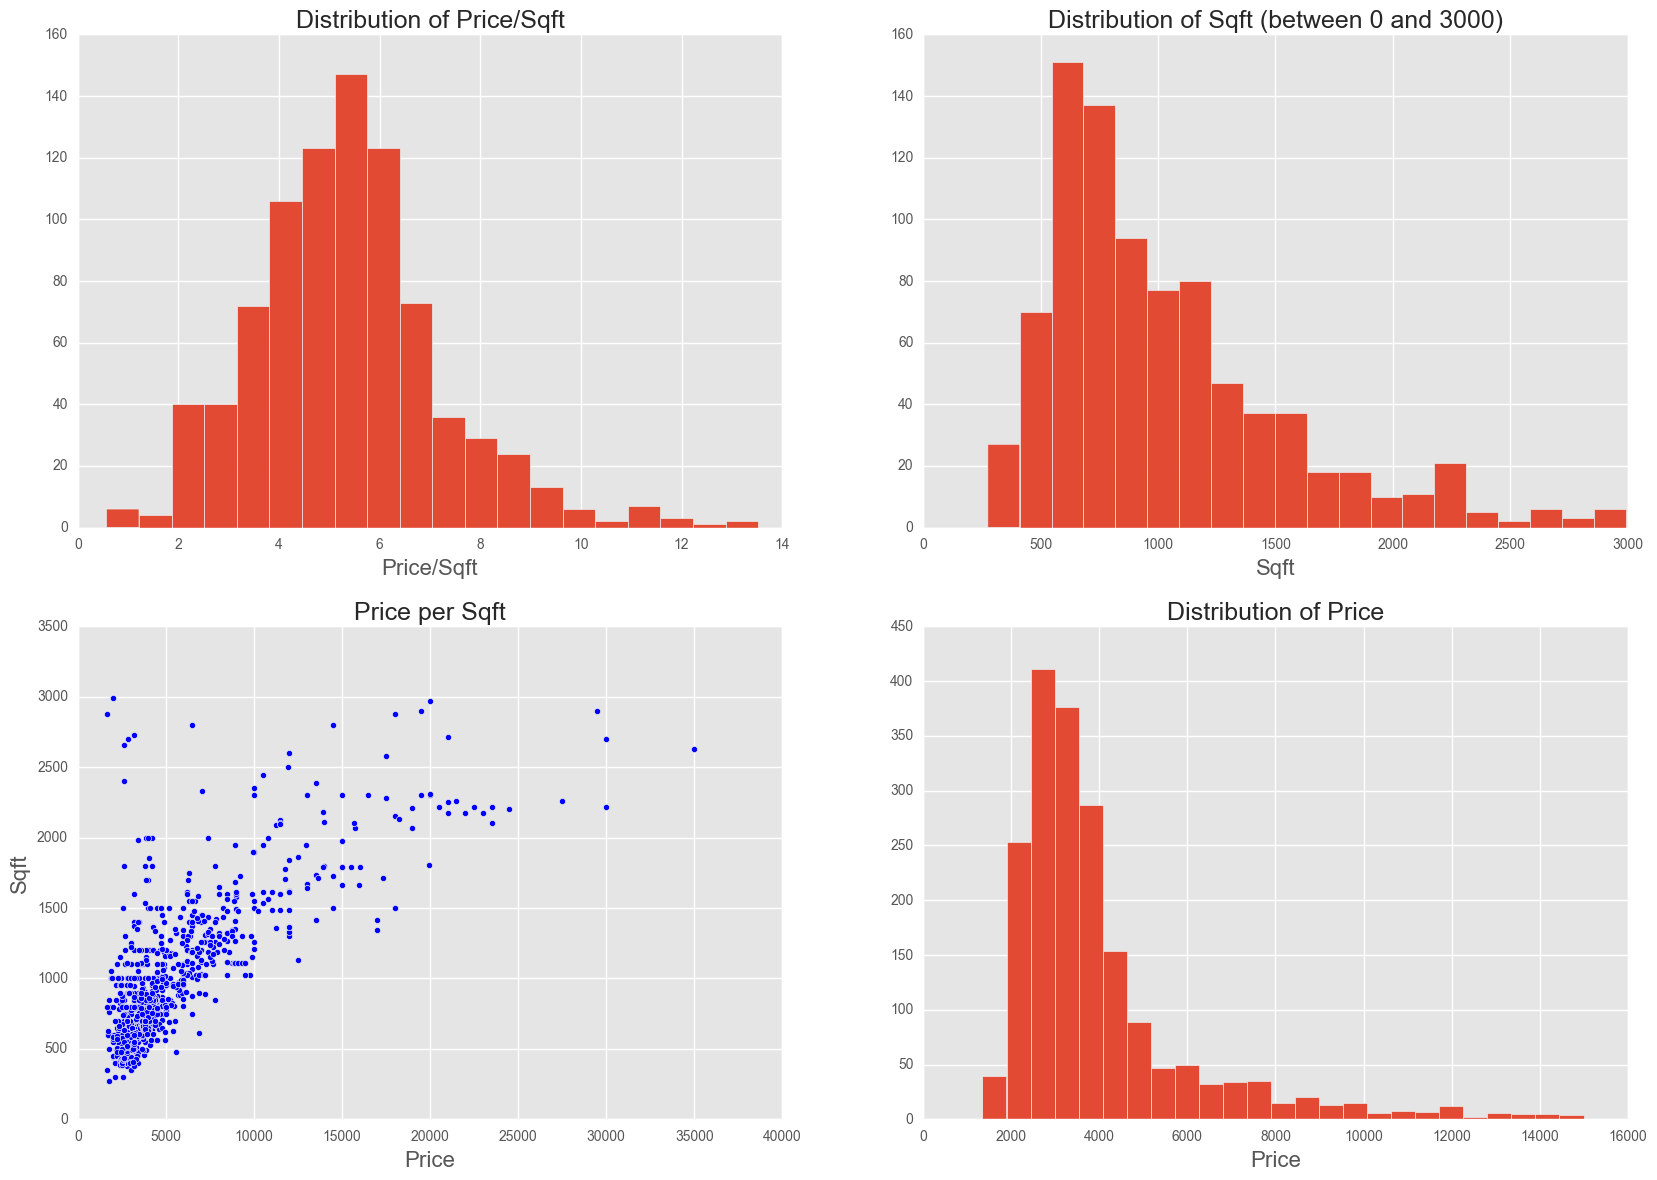

In [147]:
fig,axes = plt.subplots(2,2,figsize=(20,14))
axes[0][0].hist(x = zillow_home[zillow_home['price/sqft']>0]['price/sqft'],bins = 20) 
axes[0][0].set_title("Distribution of Price/Sqft",fontsize = 18)
axes[0][0].set_xlabel("Price/Sqft",fontsize = 16)

axes[0][1].hist(x=zillow_home[(zillow_home['sqft']>0) & (zillow_home['sqft']<3000)]['sqft'],bins=20)
axes[0][1].set_title('Distribution of Sqft (between 0 and 3000)',fontsize=18)
axes[0][1].set_xlabel('Sqft',fontsize=16)


axes[1][0].scatter(x=zillow_home[zillow_home['price/sqft']>0]['price'],y=zillow_home[zillow_home['price/sqft']>0]['sqft']);
axes[1][0].set_title('Price per Sqft',fontsize=18)
axes[1][0].set_xlabel('Price',fontsize=16)
axes[1][0].set_ylabel('Sqft',fontsize=16)
axes[1][0].set_xlim(0,40000)


axes[1][1].hist(x=zillow_home[zillow_home['price']<15000]['price'],bins=25)
axes[1][1].set_title('Distribution of Price',fontsize=18)
axes[1][1].set_xlabel('Price',fontsize=16);

In [157]:
# with open('zillow_files/home_list_pull.json', 'r') as fp:
#     home_list_pull = json.load(fp)

#     zipcode_list = []
# for x in home_list_pull:
#     zipcode = x.split('/')[4].split('-')[-1]
#     zipcode_list.append(zipcode)
# url_zip = pd.Series(home_list_pull).to_frame('list_url')
# url_zip = pd.concat([url_zip,pd.Series(zipcode_list)],axis=1)
# url_zip.rename(columns = {0:'zipcode'},inplace = True)

# url_zip

## Predicting SQFT in Zillow